# 

# Marie as a firstname over time and departements

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import descartes

from pynsee.download import download_file, get_file_list
from pynsee.geodata import get_geodata_list, get_geodata

In [2]:
meta = get_file_list()
dfraw = download_file("PRENOM_DEP")

Extracting: 100%|██████████| 76.3M/76.3M [00:00<00:00, 185MB/s]


Downloading:  27%|██▋       | 3.42M/12.8M [00:00<00:01, 6.06MiB/s]

Downloading:  31%|███▏      | 4.01M/12.8M [00:00<00:01, 5.89MiB/s]

Downloading:  38%|███▊      | 4.88M/12.8M [00:00<00:01, 6.80MiB/s]

Downloading:  43%|████▎     | 5.55M/12.8M [00:00<00:01, 6.43MiB/s]

Downloading:  48%|████▊     | 6.18M/12.8M [00:01<00:01, 5.61MiB/s]

Downloading:  53%|█████▎    | 6.73M/12.8M [00:01<00:01, 4.77MiB/s]

Downloading:  56%|█████▋    | 7.22M/12.8M [00:01<00:02, 2.34MiB/s]

Downloading:  59%|█████▉    | 7.58M/12.8M [00:02<00:03, 1.39MiB/s]

Downloading:  61%|██████▏   | 7.85M/12.8M [00:02<00:04, 1.20MiB/s]

Downloading:  63%|██████▎   | 8.06M/12.8M [00:03<00:04, 1.10MiB/s]

Downloading:  64%|██████▍   | 8.23M/12.8M [00:03<00:04, 1.02MiB/s]

Downloading:  66%|██████▌   | 8.43M/12.8M [00:03<00:04, 1.13MiB/s]

Downloading:  68%|██████▊   | 8.65M/12.8M [00:03<00:03, 1.30MiB/s]

Downloading:  69%|██████▉   | 8.83M/12.8M [00:03<00:03, 1.28MiB/s]

Downloading:  70%|███████   | 8.98M/12.8M [00:03<00:03, 1.11MiB/s]

Downloading:  73%|███████▎  | 9.35M/12.8M [00:04<00:02, 1.59MiB/s]

Downloading:  80%|███████▉  | 10.2M/12.8M [00:04<00:00, 3.08MiB/s]

Downloading:  87%|████████▋ | 11.1M/12.8M [00:04<00:00, 4.45MiB/s]

Downloading:  91%|█████████ | 11.6M/12.8M [00:04<00:00, 2.25MiB/s]

Downloading:  94%|█████████▍| 12.0M/12.8M [00:05<00:00, 1.42MiB/s]

Downloading:  97%|█████████▋| 12.3M/12.8M [00:05<00:00, 1.22MiB/s]

Downloading:  98%|█████████▊| 12.6M/12.8M [00:06<00:00, 1.10MiB/s]

Downloading: 100%|█████████▉| 12.8M/12.8M [00:06<00:00, 1.12MiB/s]

Downloading: : 12.9MiB [00:06, 978kiB/s]                          

Downloading: : 13.0MiB [00:06, 2.02MiB/s]


/home/coder/local/bin/conda/envs/basesspcloud/lib/python3.10/site-packages/pynsee/download/_download_store_file.py:68: UserWarning: File in insee.fr modified or corrupted during download
  warnings.warn("File in insee.fr modified or corrupted during download")

Extracting:   0%|          | 0.00/76.3M [00:00<?, ?B/s]

Extracting:  27%|██▋       | 20.8M/76.3M [00:00<00:00, 218MB/s]

Extracting:  55%|█████▍    | 41.6M/76.3M [00:00<00:00, 216MB/s]

Extracting:  82%|████████▏ | 62.4M/76.3M [00:00<00:00, 216MB/s]

Extracting: 100%|██████████| 76.3M/76.3M [00:00<00:00, 216MB/s]

Data file missing in the zip file:
dpt2020.csv
Following file has been used instead:
dpt2021.csv
Please report this issue

In [3]:
list_dep = list(dfraw.dpt.unique()) + ['2A', '2B']
list_year = ["1900", "1936", "1965", "2015"]

In [4]:
# compute frequency of marie as a firstname given to female babies
df = dfraw[(dfraw["sexe"] == "2") & (dfraw["annais"].isin(list_year))].reset_index(drop=True)
df["nombre"] = pd.to_numeric(df["nombre"])

df.loc[(df["dpt"] == "78"), 'dpt'] = '75'
df = df.groupby(['dpt', 'annais', 'preusuel'], as_index=False).nombre.agg('sum')
df["tot"] = df.groupby(['dpt', 'annais'], as_index=False).nombre.transform('sum')
marie = df[(df["preusuel"] == "MARIE")].reset_index(drop=True)
marie['pct'] = marie.nombre / marie.tot * 100

In [5]:
# get geographical limits of departements
geodata_list = get_geodata_list()
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
dep = dep.translate()
dep = dep.rename(columns={'insee_dep': 'dpt'})

In [6]:
DF = pd.concat([pd.DataFrame({'dpt': list_dep, 'annais': y}) for y in list_year])
DF = DF.merge(marie, how = 'left', on = ['dpt', 'annais'])

In [7]:
# data correction
# due to administrative changes in Paris region
# for all years a common value is computed for the following departement : '75', '91', '92', '93', '94', '95', '78'
# departement in Corsica are reported together

for y in list_year:
    valParis = DF.loc[(DF['annais'] == y) & (DF['dpt'] == '75'), 'pct'].values
    valCorse = DF.loc[(DF['annais'] == y) & (DF['dpt'] == '20'), 'pct'].values
    
    for d in ['91', '92', '93', '94', '95', '78']:
        valdep = DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'].values
        if np.isnan(valdep):
            DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'] = valParis
            
    for d in ['2A', '2B']:
        valdep = DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'].values
        if np.isnan(valdep):
            DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'] = valCorse

DF['pct'] = DF['pct'].fillna(0)

In [8]:
DF = DF.merge(dep, how = 'left', on = 'dpt')
datamap = gpd.GeoDataFrame(DF)

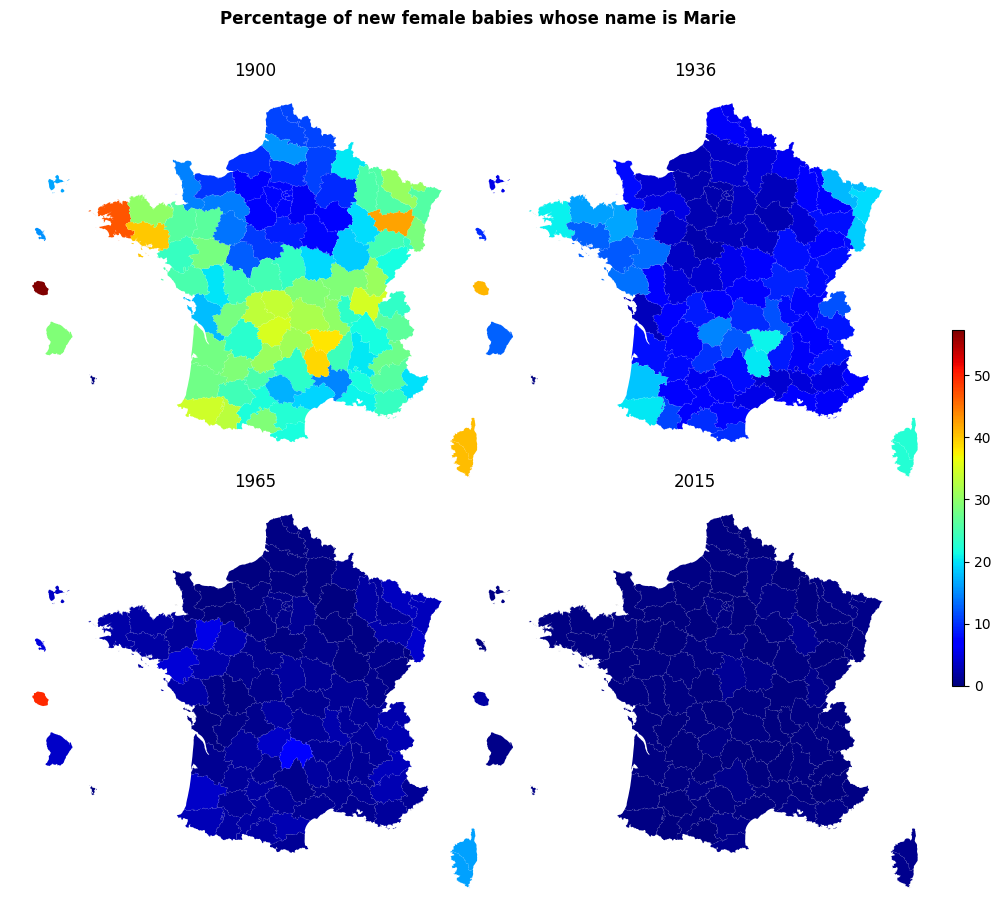

In [9]:
# make plot

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axes = axes.flatten()

normalize = mcolors.Normalize(vmin=datamap.pct.min(), vmax=datamap.pct.max())
colormap = cm.jet

plt.suptitle("Percentage of new female babies whose name is Marie", x = 0.3, y = 0.9,
             horizontalalignment= 'left',
             fontsize = 12, fontweight='bold')

for a, ax in zip(np.unique(datamap.annais.values), axes):
    
    ax.set_axis_off()
    dt = datamap[datamap.annais == a]
    p = dt.plot(column='pct', ax=ax, cmap=colormap,norm=normalize)
    ax.set_title(a)
    
bbox = ax.get_position() 
cax = fig.add_axes([bbox.x1 + 0.01, bbox.y0 + 0.2, 0.01, bbox.height])
    
fig.colorbar(cm.ScalarMappable(norm=normalize, cmap=colormap), cax=cax)
plt.subplots_adjust(hspace=-0.2, wspace=-0.1)

plt.show()